In [1]:
import os
import cv2
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

GAME_STATE_FILE_NAME = "game"
GAME_STATE_FILE_EXT = ".csv"
GAMES_DIR = "games/"
PROCESSED_GAMES_DIR = "processed_games/"
MODEL_NAME = "2048_model.h5"
MOVES = ["UP", "DOWN", "LEFT", "RIGHT"]
MOVE_COL_NAME = "MOVE"
FILE_HEADER = [""]
N_SIZE = 4
N_FILES = len(os.listdir(GAMES_DIR))
MAX_CELL_VALUE_THRESHOLD = 12

def load_data(file, direc=GAMES_DIR, header=True):
    csv_path = os.path.join(direc, file)
    if header:
        return pd.read_csv(csv_path)
    else:
        return pd.read_csv(csv_path, header=None)

In [2]:
def extract_move(row):
    move = np.int16(row[len(row) - 1])
    row = row[:len(row) - 1]
    return move, row

In [3]:
def normalize_row(row):
    row = np.float16(row)
    row = np.add(row, 1)
    row = np.log2(row)
    row = np.int16(row)
    
    min_val = 100
    for val in row:
        if val == 0:
            continue
        
        if min_val > val:
            min_val = val
            
    if min_val > 0:
        row = np.subtract(row, min_val - 1)
        
    row_max = np.max(row)
    row = row / row_max
    row = np.round(row, 6)
    return row


In [4]:
def get_stringy_row(row):
    return str(row)

def update_record(record_dict, row, move):
    row_str = get_stringy_row(row)
    if record_dict.__contains__(row_str):
        moves = record_dict[row_str]
    else:
        moves = np.array([0,0,0,0])

    moves[move] = moves[move] + 1
    record_dict[row_str] = moves
    return record_dict
        

In [5]:
def get_rot_template():
    rot_move_map = {}
    # Moves: UDLR -> 0123 
    # Movement: 0->2, 2->1, 1->3, 3->0
    rot_move_map[0] = 2
    rot_move_map[2] = 1
    rot_move_map[1] = 3
    rot_move_map[3] = 0
    return rot_move_map

def augment_data(row, move):
    rot_move_map = get_rot_template()
    row_2d = row.reshape(4,4)
    aug_row_arr = []
    moves_arr = []
    for n in range(len(rot_move_map)):
        row_2d = np.rot90(row_2d, 1)
        row = np.array(row_2d.flatten())
        move = rot_move_map[move]
        row = np.append(row, move)
        aug_row_arr.append(row)
        
    return aug_row_arr


Graphs for game 0 :



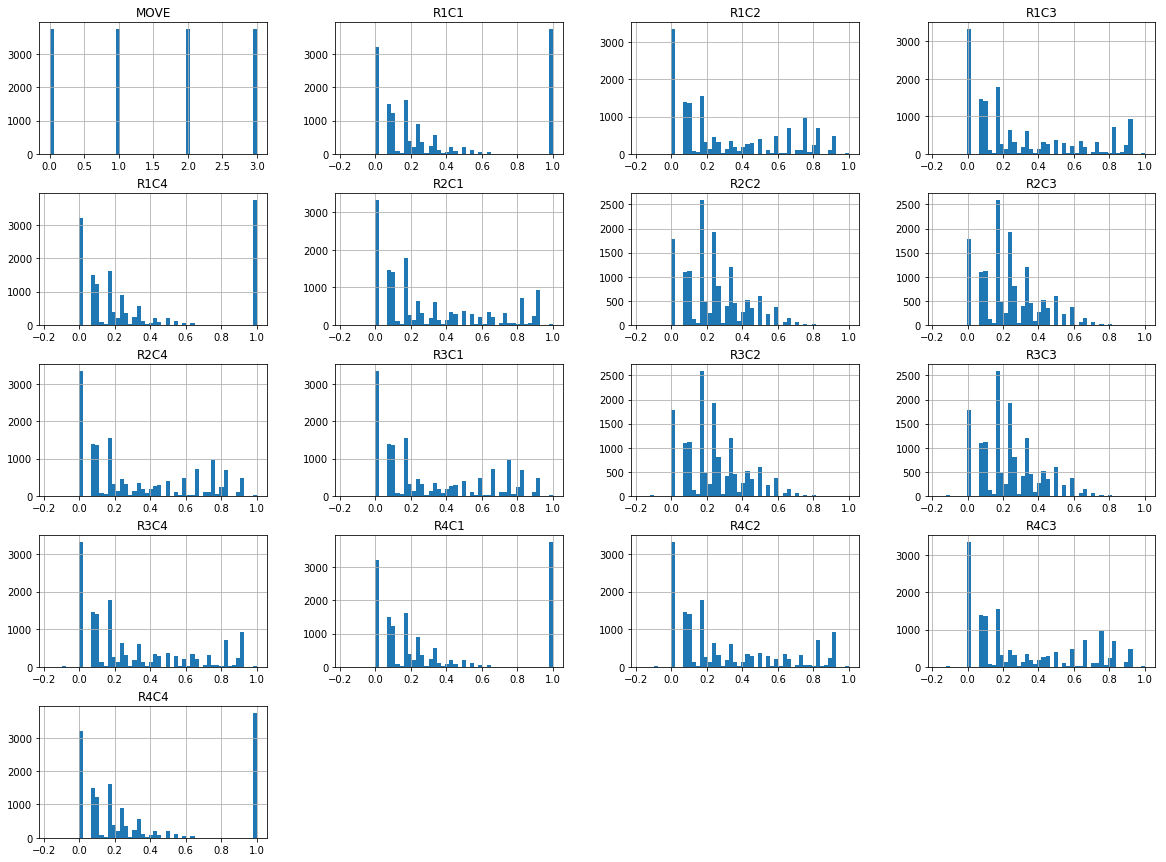

Graphs for game 1 :



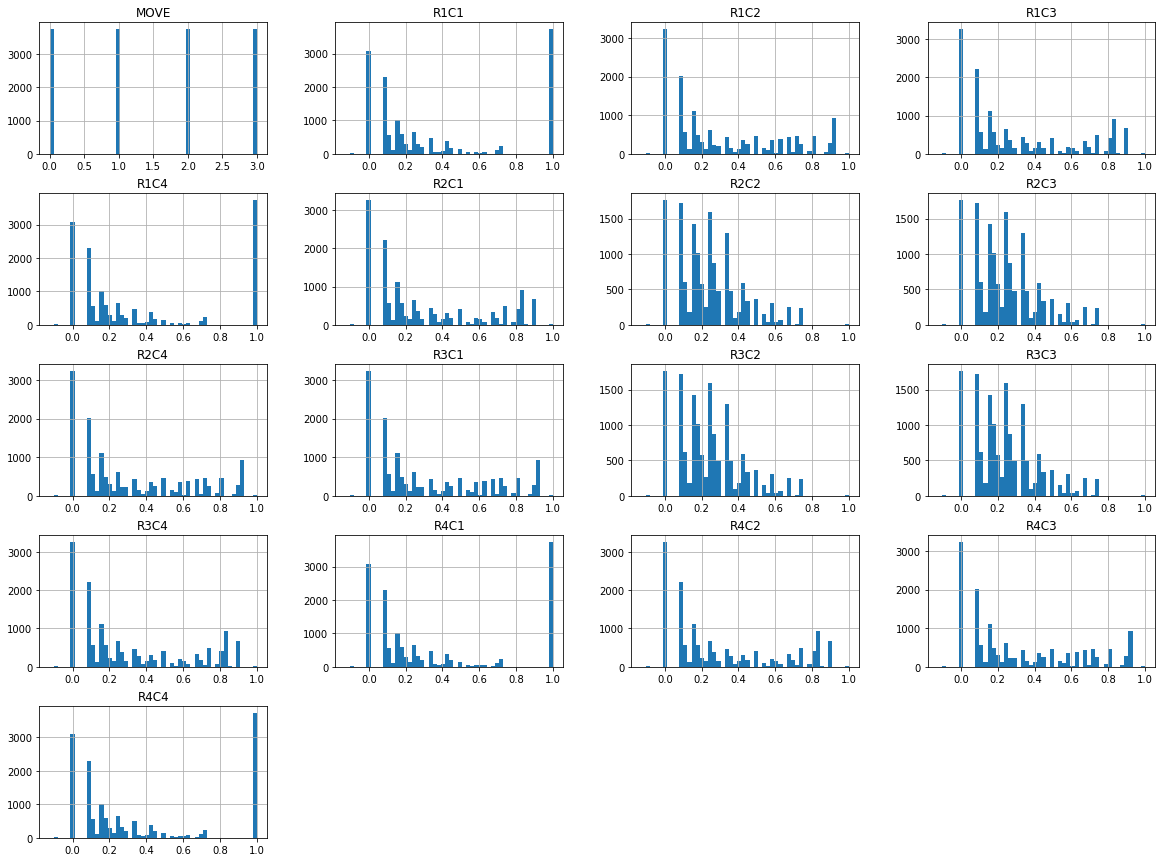

Graphs for game 2 :



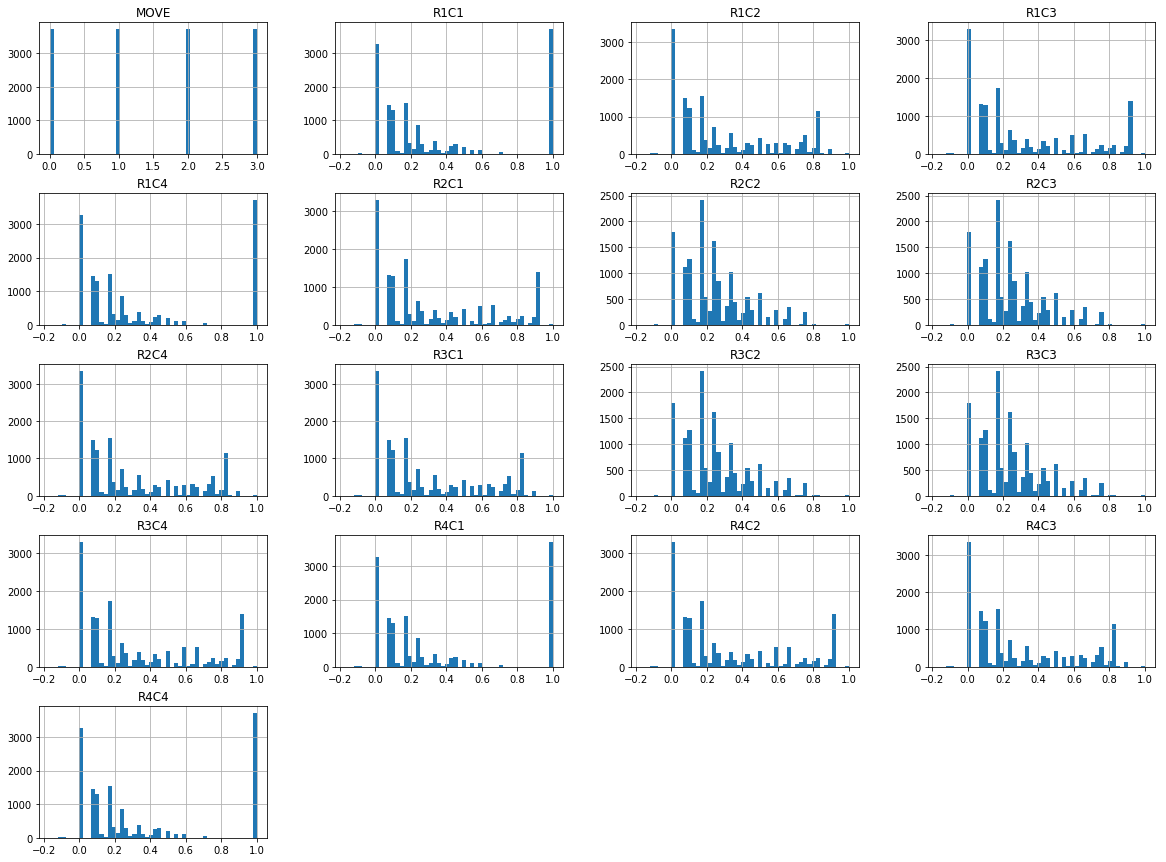

Graphs for game 3 :



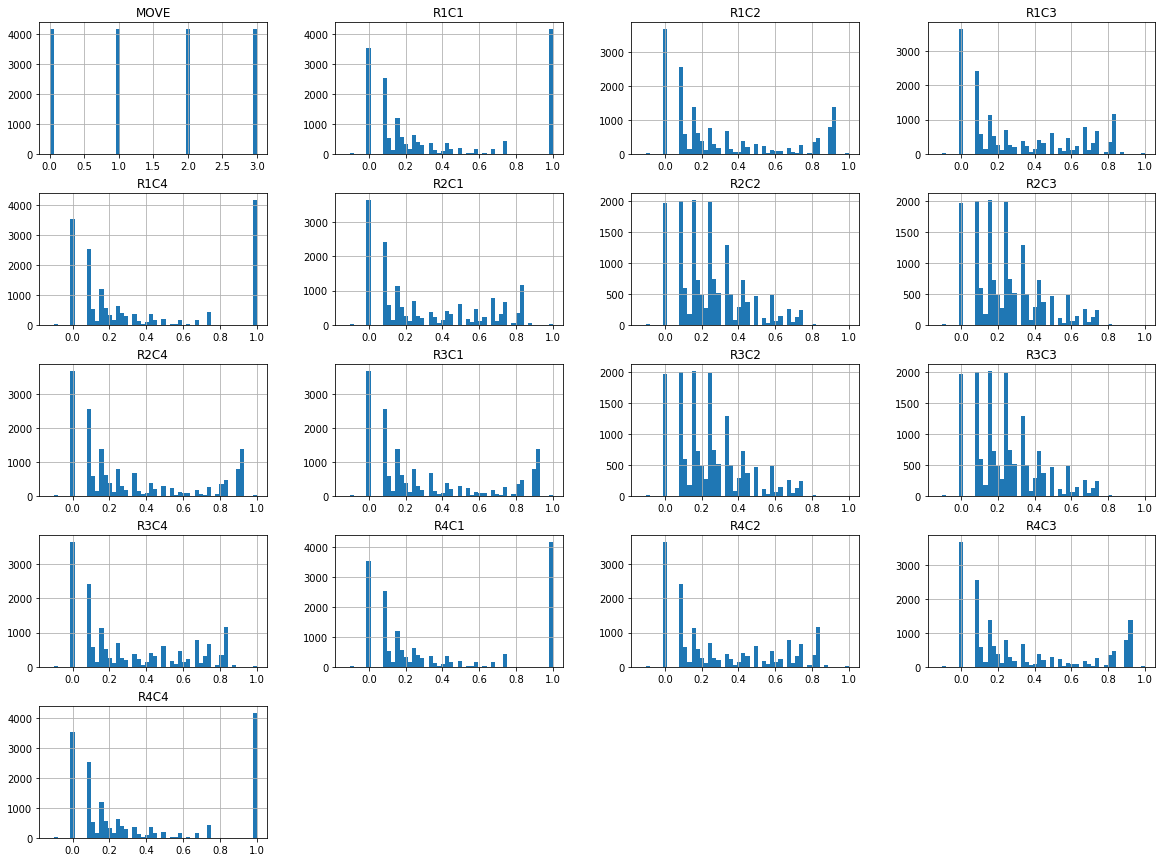

Graphs for game 4 :



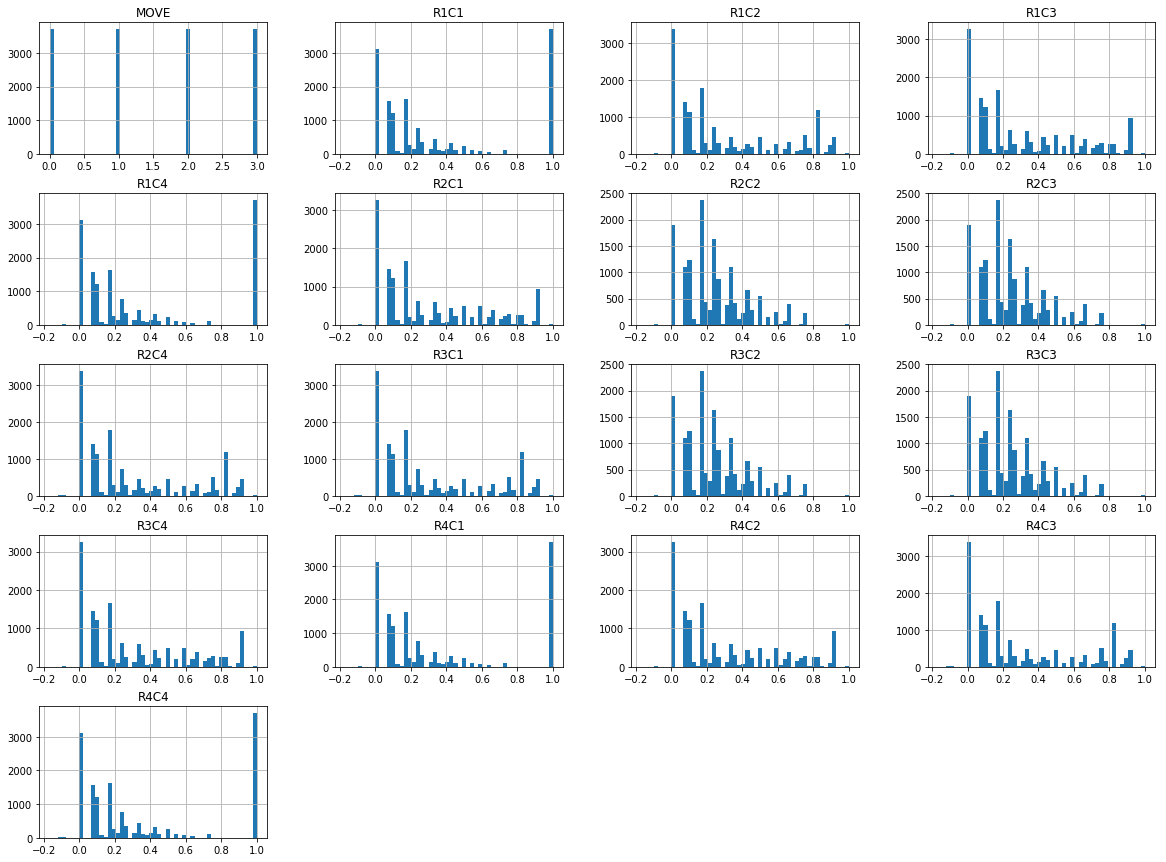

Graphs for game 5 :



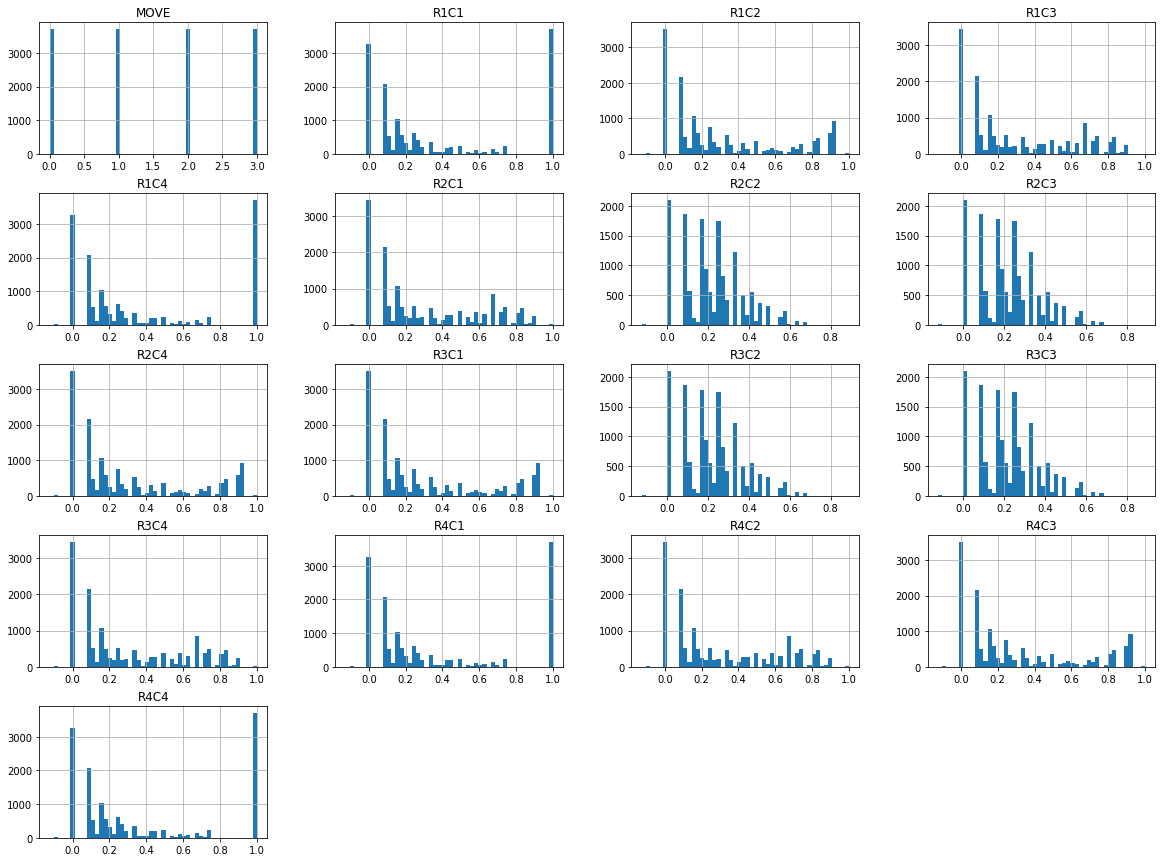

Graphs for game 6 :



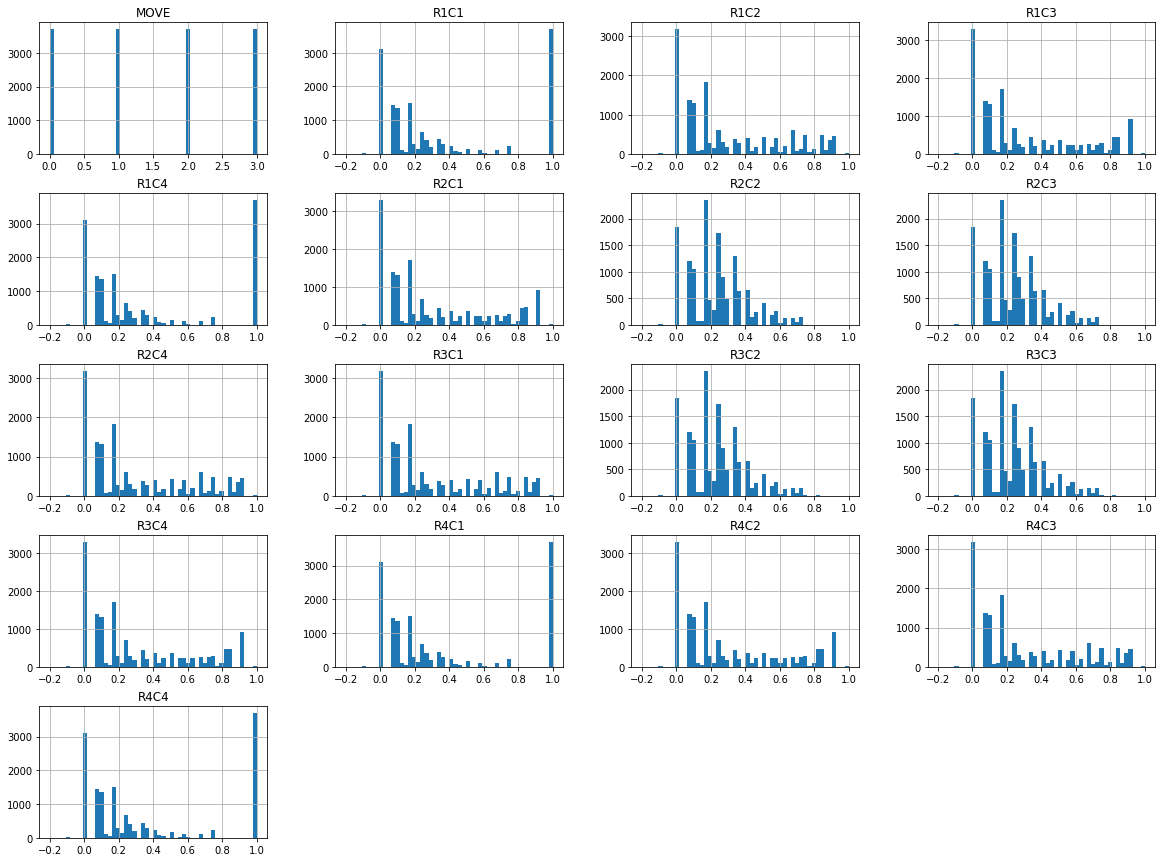

Graphs for game 7 :



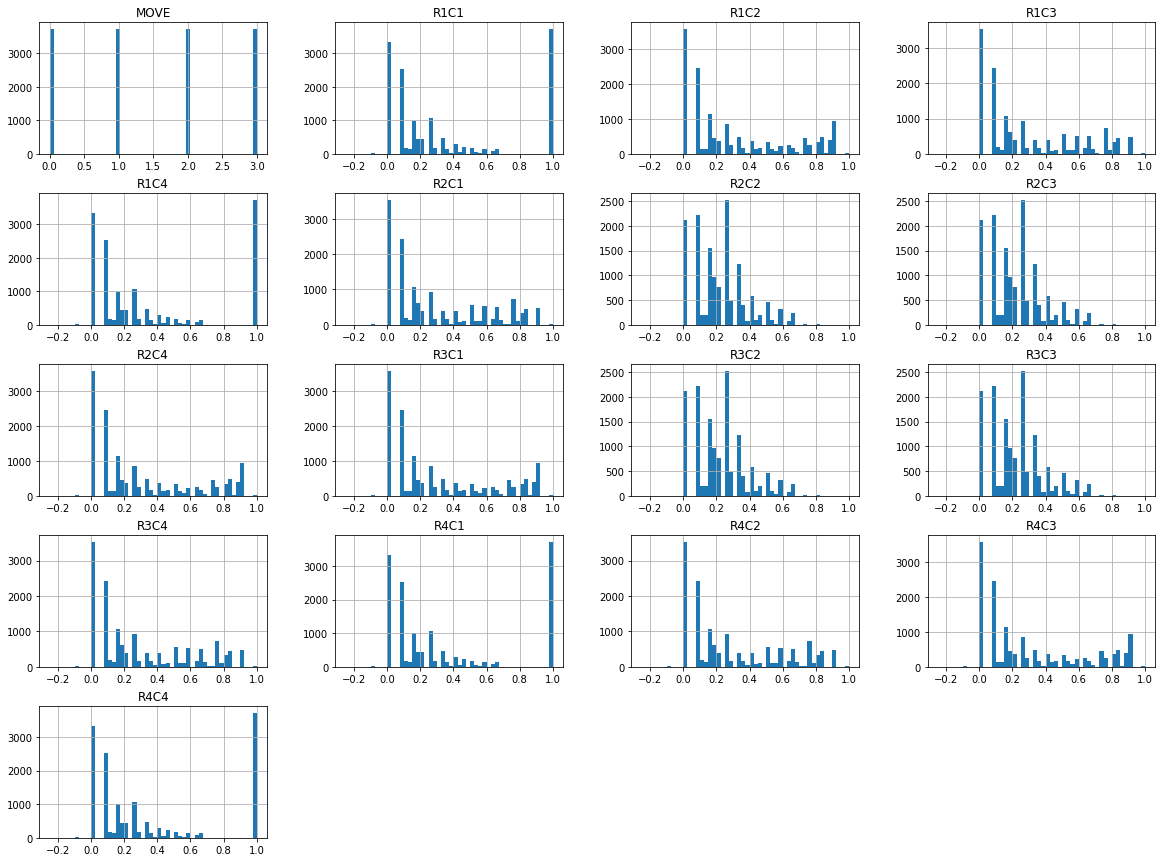

Graphs for game 8 :



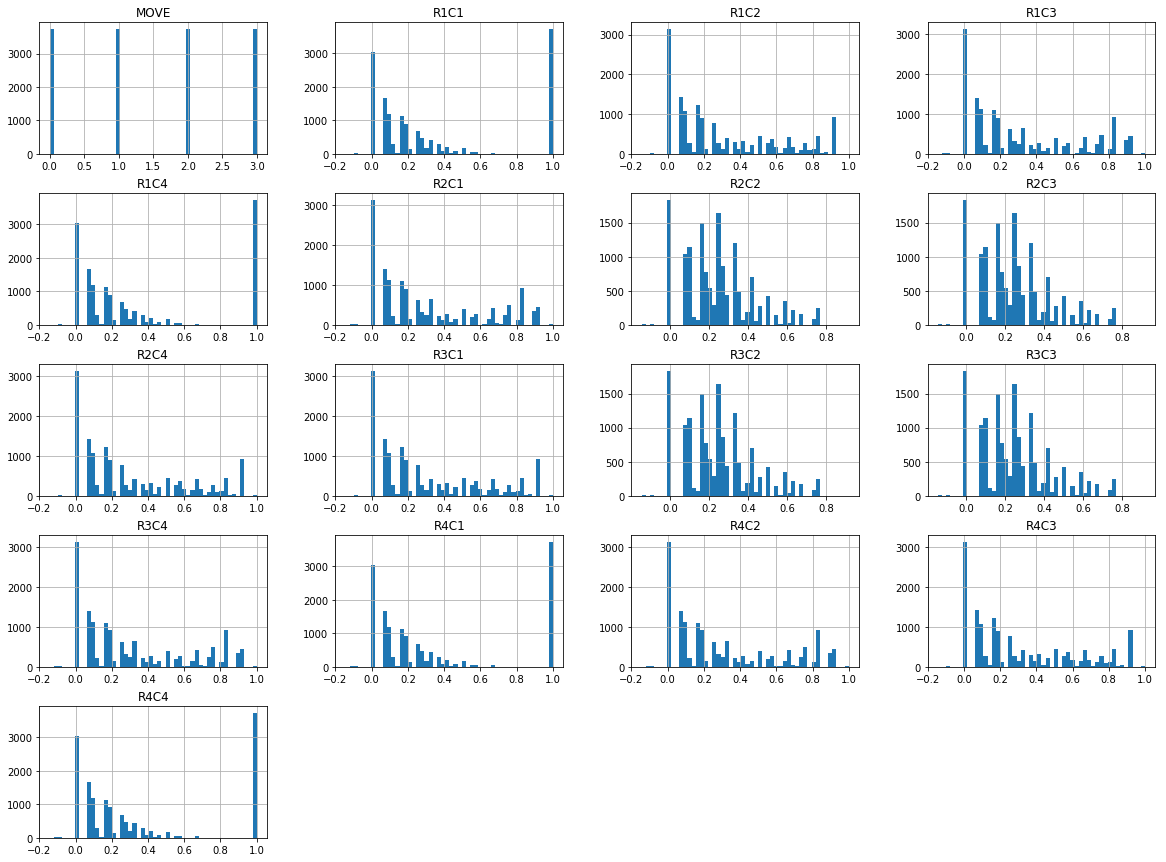

Graphs for game 9 :



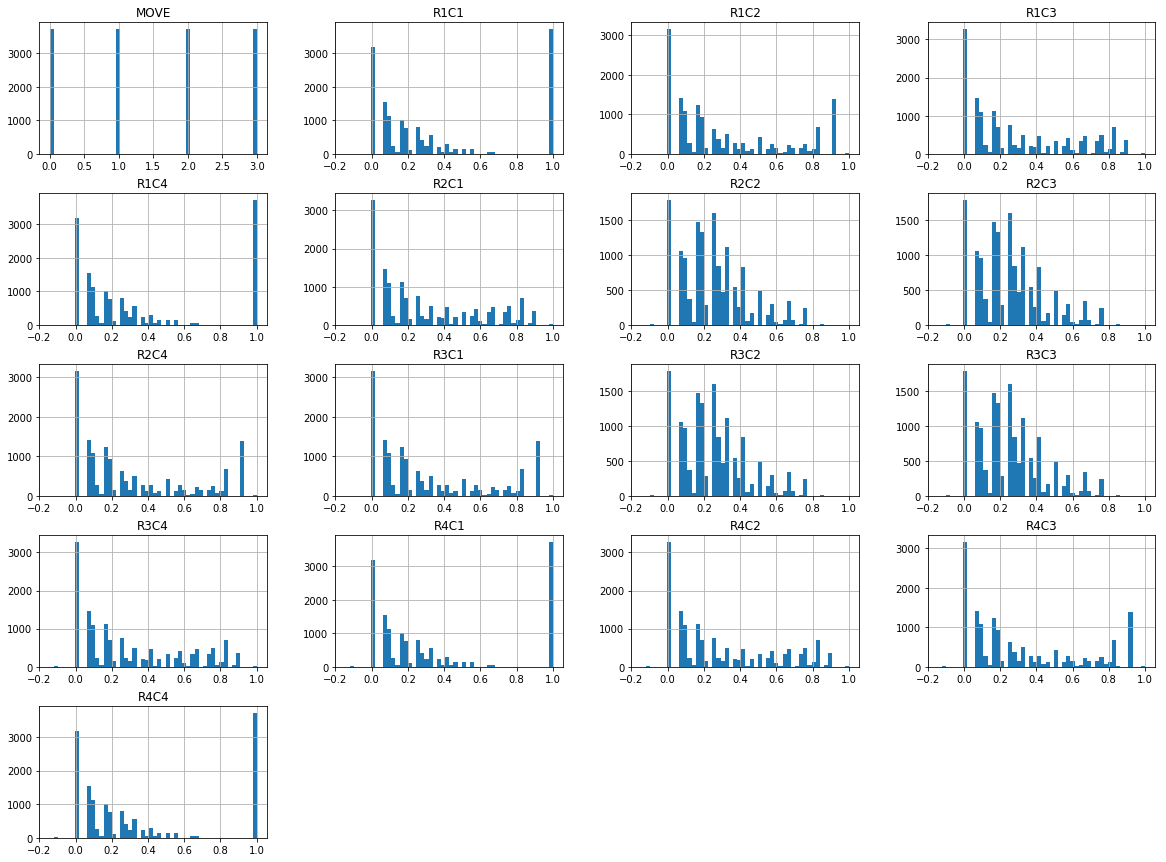

Graphs for game 10 :



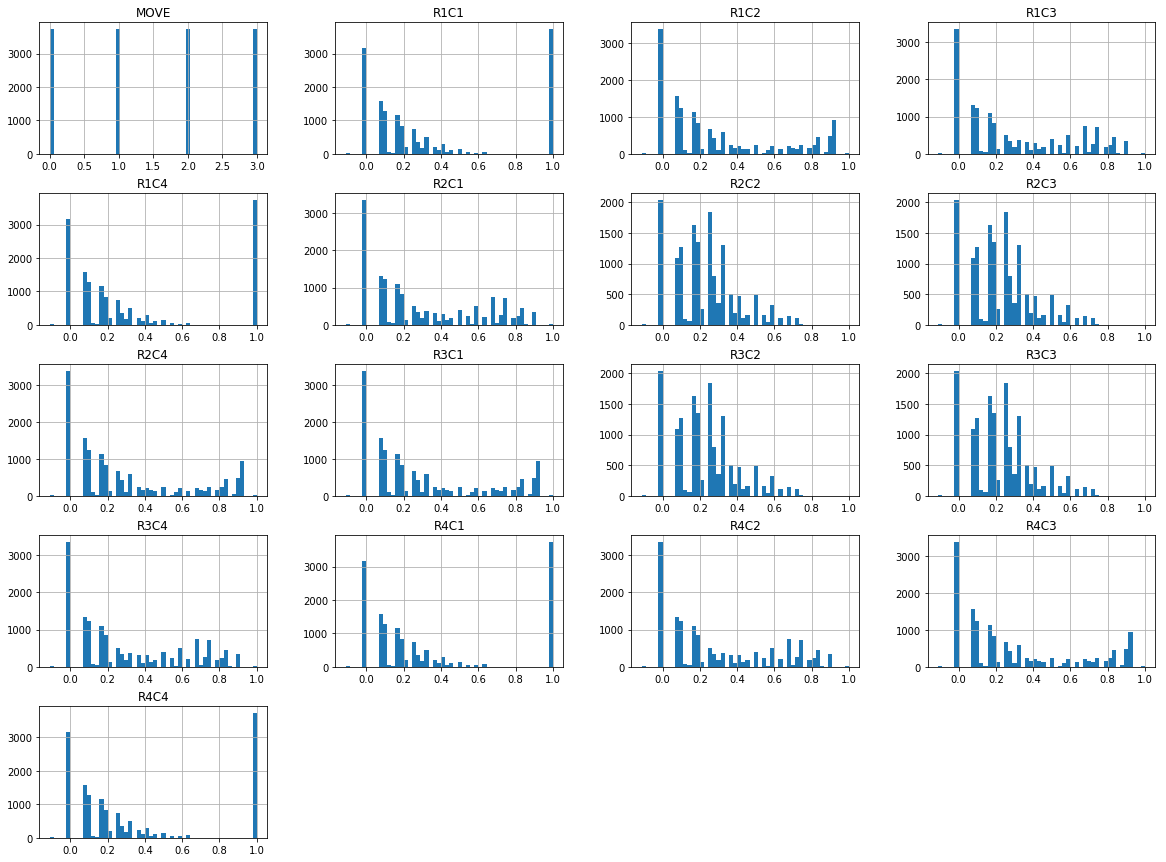

Graphs for game 11 :



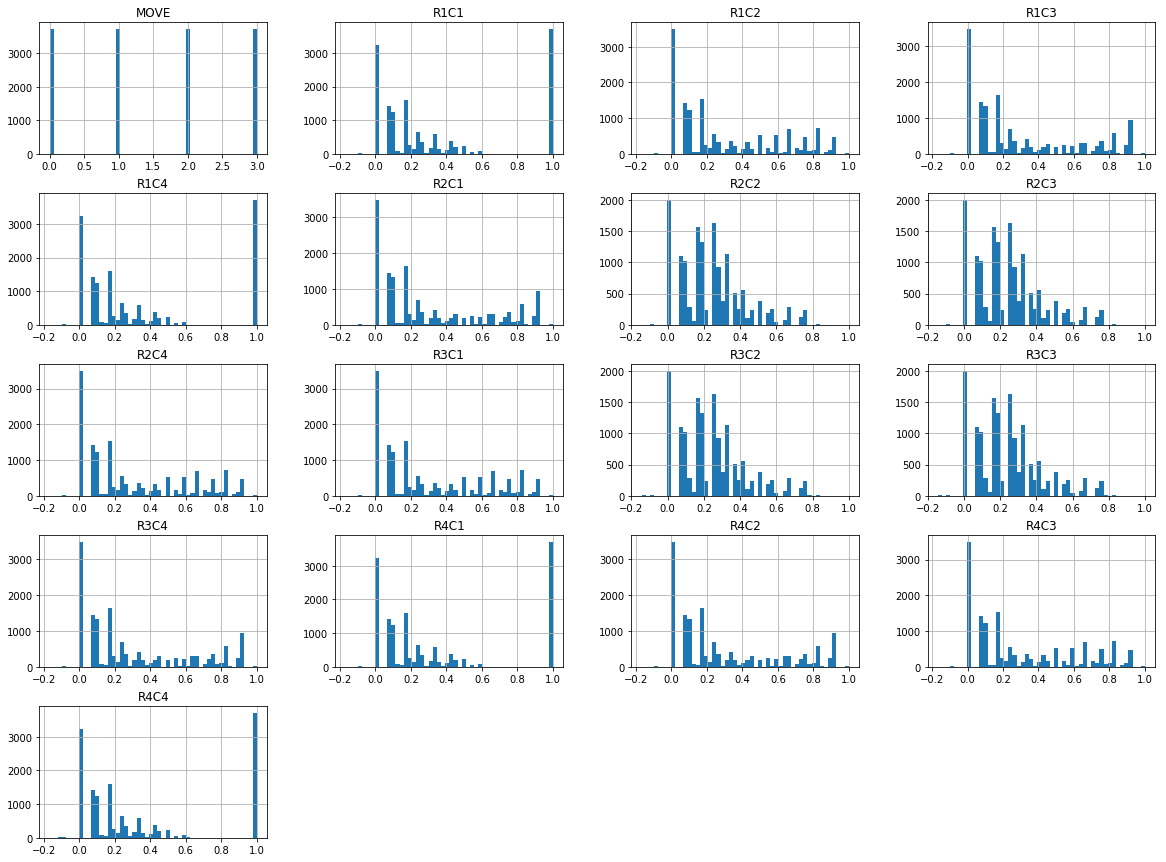

Graphs for game 12 :



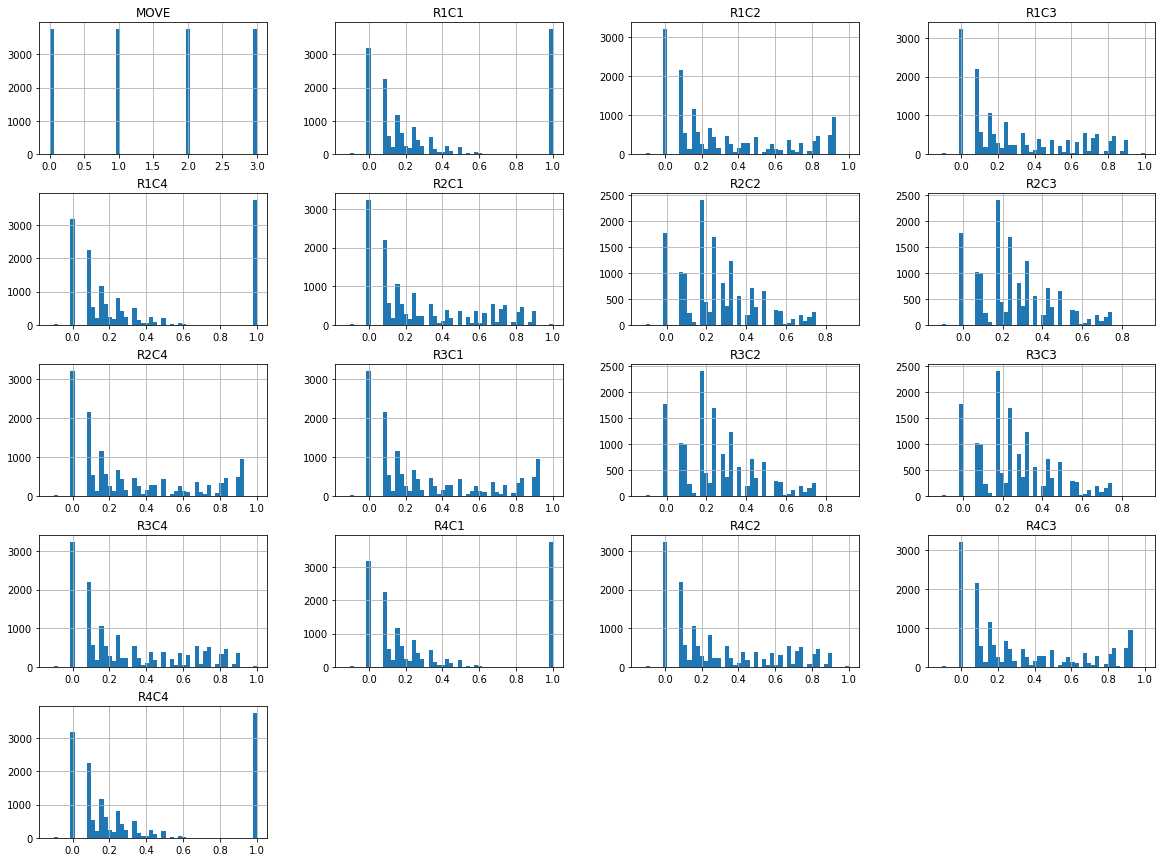

Graphs for game 13 :



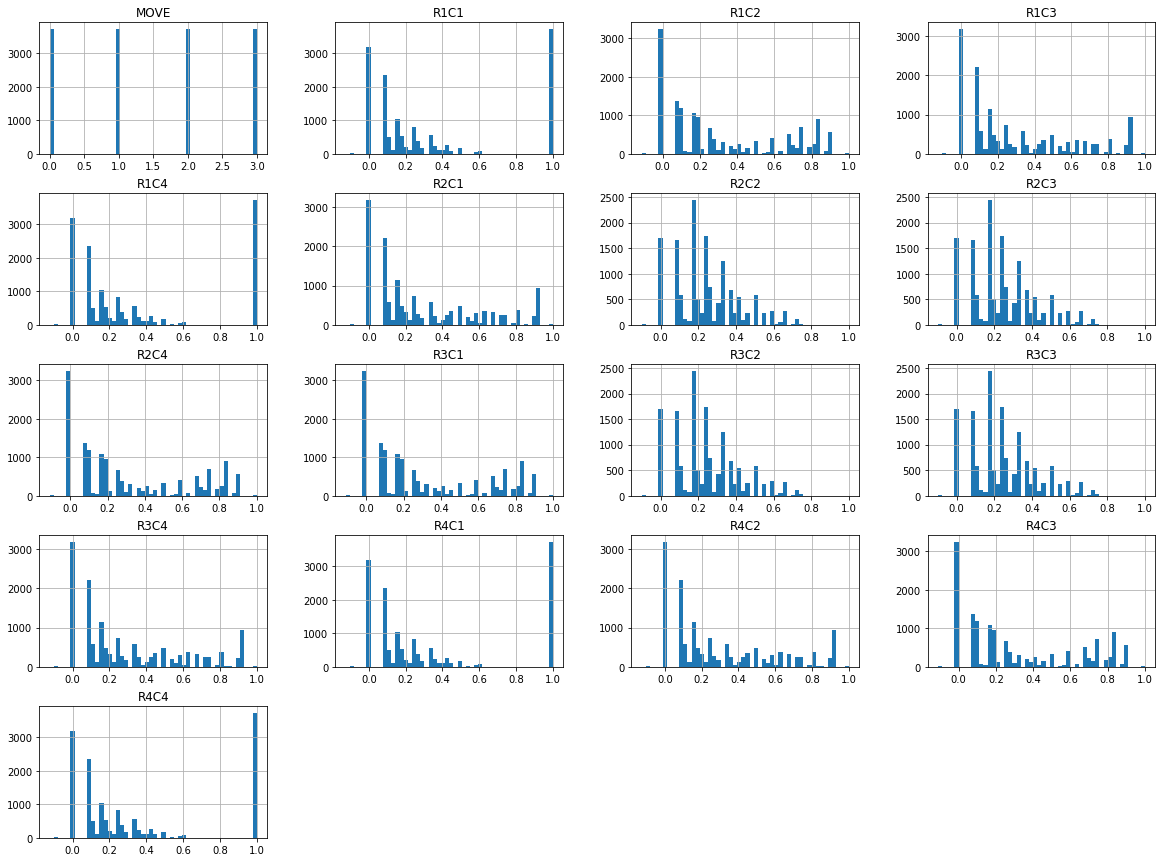

Graphs for game 14 :



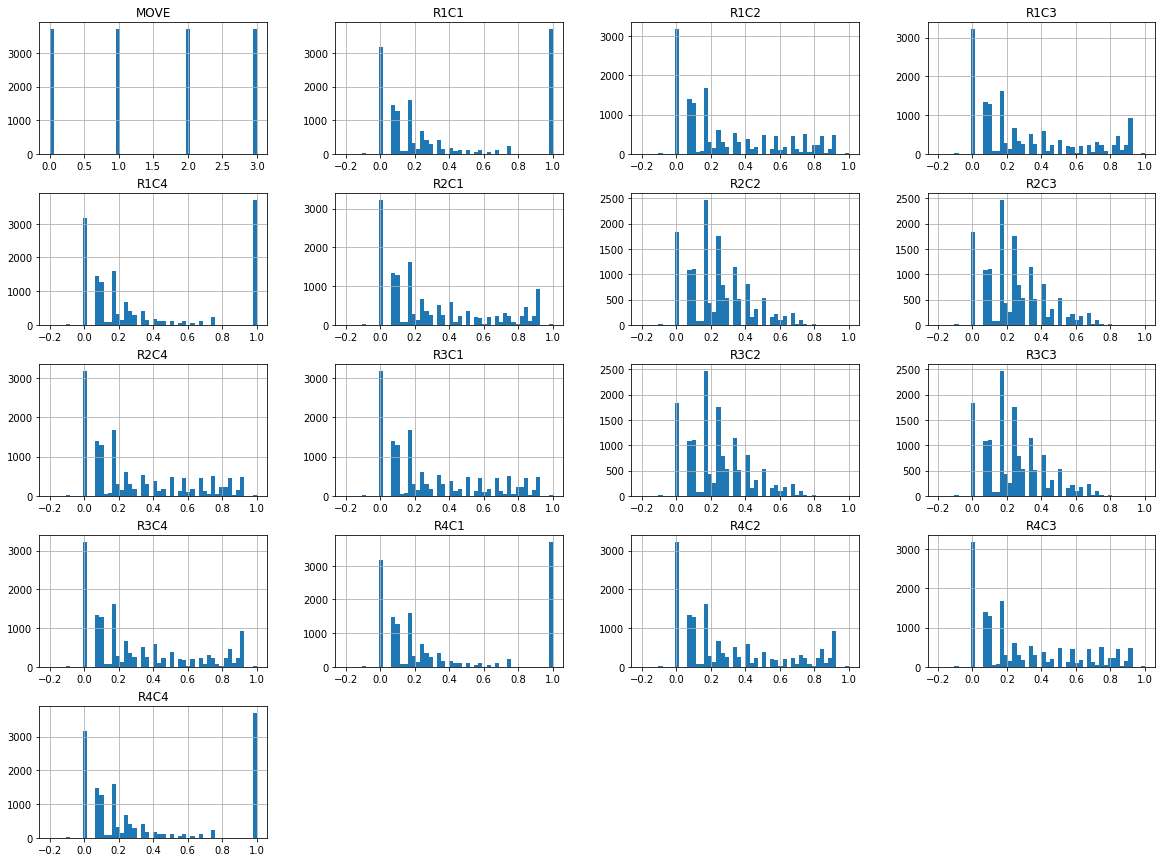

Graphs for game 15 :



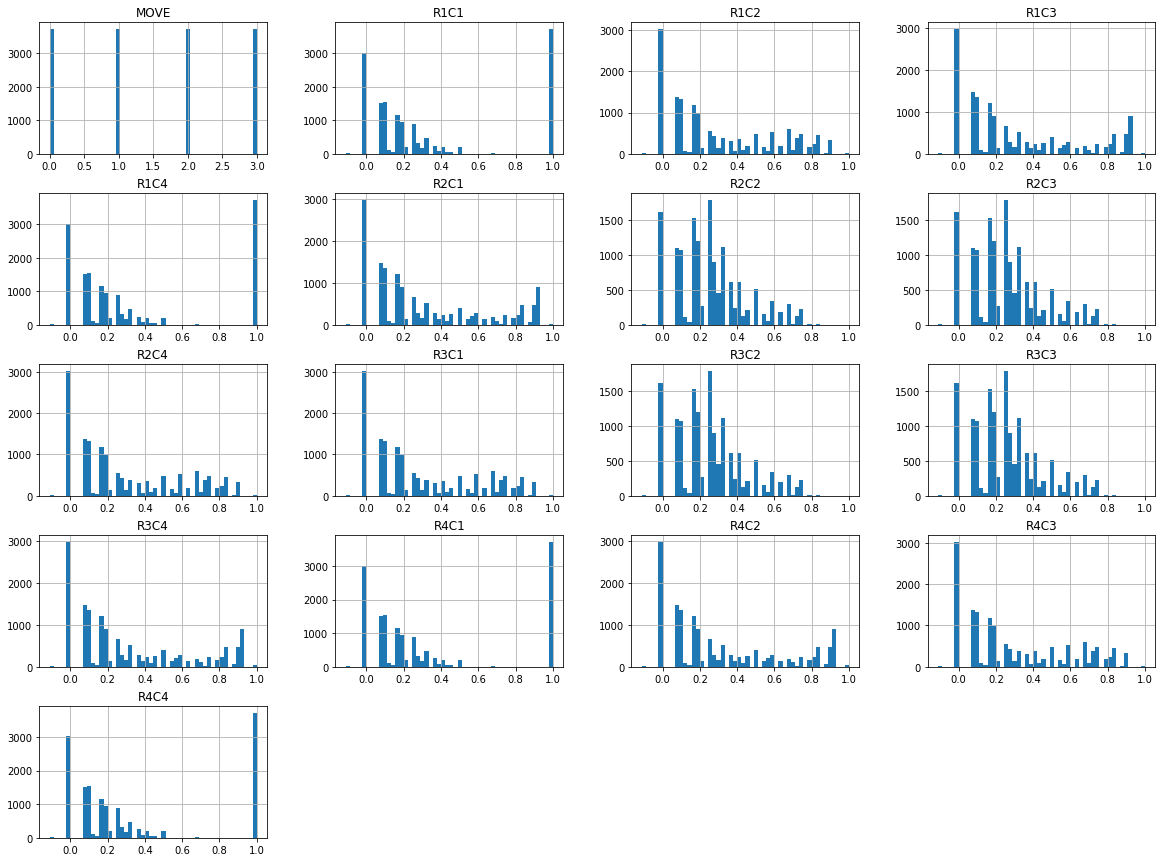

Graphs for game 16 :



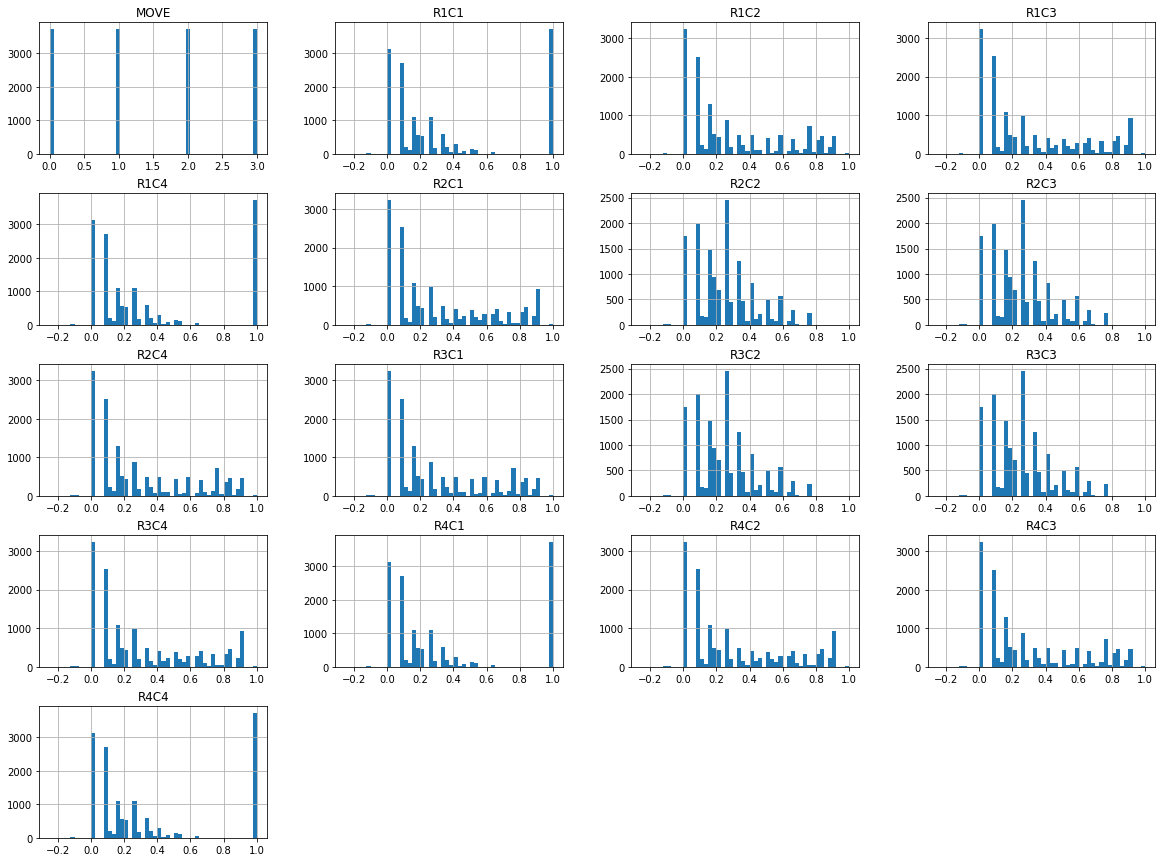

Graphs for game 17 :



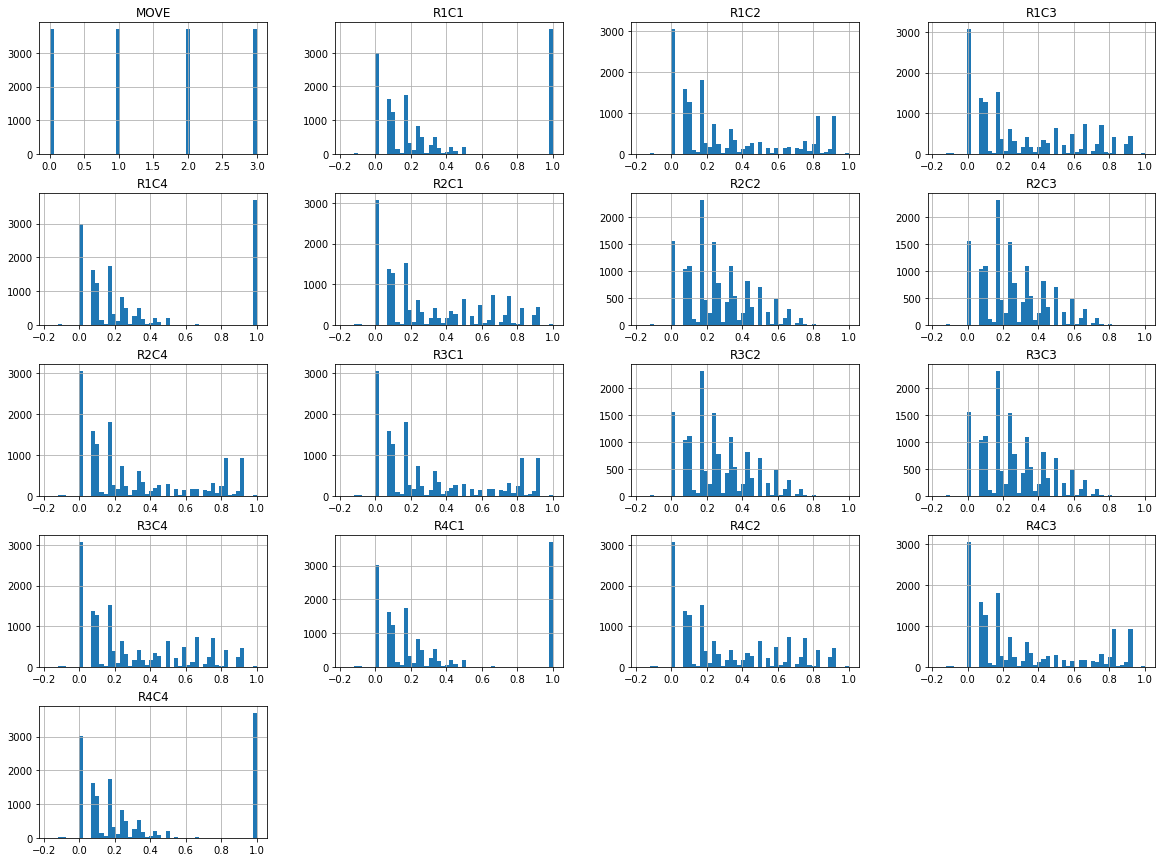

In [6]:
record_dict = {}
total_moves = 0
dropped_counter = 0
for n_file in range(N_FILES):
    filename = GAME_STATE_FILE_NAME + str(n_file) + GAME_STATE_FILE_EXT
    data = load_data(file=filename, direc=GAMES_DIR)
    data_col = data.columns
    data = np.float32(data.values)
    augmented_data = []
    for n_row in range(len(data)):
        row = data[n_row]
        move, row = extract_move(row)
        if np.max(row) > (2**MAX_CELL_VALUE_THRESHOLD):
            dropped_counter = dropped_counter + 1
            continue
            
        row = normalize_row(row)
        aug_row_arr = augment_data(row, move)
        augmented_data.extend(aug_row_arr)
        
    augmented_data = np.array(augmented_data)
    data = augmented_data
    total_moves = total_moves + len(data)
    processed_data = pd.DataFrame(data, columns=data_col)
    processed_data.to_csv(PROCESSED_GAMES_DIR + GAME_STATE_FILE_NAME + str(n_file) + GAME_STATE_FILE_EXT, sep=',', encoding='utf-8', index=False)
    print("Graphs for game", n_file, ":\n")
    %matplotlib inline
    processed_data.hist(bins=50, figsize=(20,15))
    plt.show()
    
    for row in augmented_data:
        move, row = extract_move(row)
        record_dict = update_record(record_dict, row, move)

In [13]:
total_counter = 0
polluted_counter = 0
for row_str in record_dict.keys():
    total_counter = total_counter + 1
    record = record_dict[row_str]
    is_polluted = (np.max(record) / np.sum(record)) < 1
    if is_polluted:
        polluted_counter = polluted_counter + 1
        print("Polluted Records: ", record)
    
print("total_moves", total_moves)
print("total_counter", total_counter)
print("polluted_counter", polluted_counter)
print("dropped_counter",dropped_counter)

Polluted Records:  [0 0 1 1]  for:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Polluted Records:  [1 1 0 0]  for:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Polluted Records:  [1 0 0 1]  for:  [0.142857 0.       0.571429 1.       0.       0.       0.428571 0.571429
 0.       0.428571 0.285714 0.428571 0.142857 0.285714 0.142857 0.285714]
Polluted Records:  [1 0 1 0]  for:  [1.       0.571429 0.428571 0.285714 0.571429 0.428571 0.285714 0.142857
 0.       0.       0.428571 0.285714 0.142857 0.       0.       0.142857]
Polluted Records:  [0 1 1 0]  for:  [0.285714 0.142857 0.285714 0.142857 0.428571 0.285714 0.428571 0.
 0.571429 0.428571 0.       0.       1.       0.571429 0.       0.142857]
Polluted Records:  [0 1 0 1]  for:  [0.142857 0.       0.       0.142857 0.285714 0.428571 0.       0.
 0.142857 0.285714 0.428571 0.571429 0.285714 0.428571 0.571429 1.      ]
Polluted Records:  [0 0 1 1]  for:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Polluted Records:  [1 